Denne notebook beskriver hvordan man finetuner Gemma2-2B for at tilføje function calling og reasoning infrence steps.
Det er training-time thinking idet modellen fintunes på et datasæt af prompt eksempler - data der er genereret af en anden model.

Træning af modellen tager ca 20min på A100 GPU. For 2Billion parameter model.

# Baggrund
Jeg bruger en model som allerede er instruction finetuned og ikke en base model. Derfor kan modellen imprægneres med den nye funktionalitet, ved brug af en mindre compute tung finetuning - LORA.

Her træner man nye vægte på de relevante lag i modellen (ikke dense lag som er inde i netværket). Det generere en matrice af vægte som lægges til de originale vægte i output laget, hvilket så giver inflydelsen fra det nye adapter lag.

Ved kun at påvirke nogle vægtene i netværket, bevares grundmodellens kvalitet/funktionalitet. Man kan sige at man øger sandsynligheden for at modellen vælger at bruge nye "færdigheder" ved inferens.

# Fremgangsmåde
1. Modellen *google/gemma-2-2b-it* bruges som udgangspunkt. Den model har ingen tool calling. Eller reasoning.
1. Vi finder et datasæt som har eksempler på hvordan en model anvender tools.
1. Modificerer Tokenizer, så den ikke splitter vores nye special tokens op ('think', 'tool_call' etc.)
1. Opsætter SFTTrainer med Lora og hyperparam configs.
1. Kører træning. (supervised fine-tuning)
1. In session test af model.




# Training Datasæt
## Tool calling
NousResearch's datasæt til at lære modellen function calling strategier, er et almindeligt brugt datasæt.
> Hermes Function-calling Standard enables creation of LLM agents that are capable of executing API calls directly from user instructions. For instance, when asked to "find a flight from New York to Los Angeles for next Friday," a function-calling agent can interpret the request, generate the necessary function call (e.g., search_flights), and return the results. These agents significantly enhance the utility of AI by enabling direct interactions with APIs, making them invaluable in digital assistants across various domains.
https://huggingface.co/datasets/NousResearch/hermes-function-calling-v1

## Reasoning/CoT/`<think>`
Ved at træne modellen på et datasæt af eksempler på hvordan den skal svare på spørgsmål, kan man lede den trænede model hen mod at bruge thinking steps under inferens.
I dette datasæt (se eksempel herunder) forklares modellen, via "system" prompt, at den kan bruge værktøjer, og hvordan de skal kaldes. I "model" prompten vises modellen (som man træner) hvordan den skal resonnere og planlægge opgaven, som en slags chain-of-thought fremgangsmåde.

## Trænings datasæt
Jeg bruger datasættet "hermes-function-calling-thinking-V1" som indeholder eksempler på hvordan modellen skal håndtere både tool calls og thinking.
https://huggingface.co/datasets/Jofthomas/hermes-function-calling-thinking-V1

Datasættet er lavet til en type model der bruger en anden chat template, så det skal lige rettes til også, så den passer til Gemma2.
Metoden flætter basalt set bare en instruktion om at modellen skal tænke sig om, før den kalder tools. Derved kan datasættet flættes ind i træningsdata ved brug af standard logik (AutoTokenizer). Man kan nok godt sige at modellen ikke på magisk vis bliver en reasoning model, da den kun tænker i 1 step, men metoden forbedrer resultatet af dens output.



In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U peft
!pip install -q -U trl
!pip install -q -U tensorboardX
!pip install -q wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
from enum import Enum
from functools import partial
import pandas as pd
import torch
import json

from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer
from peft import LoraConfig, TaskType

set_seed(2)

# Set colab parameter "HF_Token". Token should have write access, so we can upload model
import os
from google.colab import userdata
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

output_dir = "gemma-2-2B-it-thinking-function_calling-V0"


In [ ]:
# Example fom the nous hermes dataset
exampleSample = [
    {
        "content": "You are a function calling AI model. You are provided with function signatures within <tools></tools> XML tags.You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug into functions.Here are the available tools:<tools> [{'type': 'function', 'function': {'name': 'get_stock_price', 'description': 'Get the current stock price', 'parameters': {'type': 'object', 'properties': {'symbol': {'type': 'string', 'description': 'The stock symbol, e.g. AAPL, GOOG'}}, 'required': ['symbol']}}}, {'type': 'function', 'function': {'name': 'calculate_distance', 'description': 'Calculate the distance between two locations', 'parameters': {'type': 'object', 'properties': {'start_location': {'type': 'string', 'description': 'The starting location'}, 'end_location': {'type': 'string', 'description': 'The ending location'}}, 'required': ['start_location', 'end_location']}}}] </tools>Use the following pydantic model json schema for each tool call you will make: {'title': 'FunctionCall', 'type': 'object', 'properties': {'arguments': {'title': 'Arguments', 'type': 'object'}, 'name': {'title': 'Name', 'type': 'string'}}, 'required': ['arguments', 'name']}For each function call return a json object with function name and arguments within <tool_call></tool_call> XML tags as follows:\n<tool_call>\n{tool_call}\n</tool_call>", "role": "system"
     },
     {
         "content": "Hi, can you tell me the current stock price of Apple?", "role": "human"
     },
     {
         "content": "<think>Okay, so the user asked, \"Hi, can you tell me the current stock price of Apple?\" I need to figure out how to respond to that. First, I remember that I have access to some tools. Let me look at the tools available. Oh, there's a function called get_stock_price. That sounds exactly like what the user is asking for.\n\nThe user mentioned Apple, and I know that Apple's stock symbol is AAPL. So, I should use that symbol in the function. The get_stock_price function requires a symbol parameter, which in this case is 'AAPL'. \n\nI don't need to call any other functions here because the user's query is straightforward—they just want the current stock price. There's no need to calculate a distance or anything else. \n\nSo, I'll construct the function call with the get_stock_price name and include the symbol as 'AAPL' in the arguments. That should fulfill the user's request accurately.\n</think><tool_call>\n{'name': 'get_stock_price', 'arguments': {'symbol': 'AAPL'}}\n</tool_call>", "role": "model"
      },
      {
          "content": "<tool_response>\n{'stock_price': '$150.75'}\n</tool_response>", "role": "tool"
      },
      {
          "content": "The current stock price of Apple (AAPL) is $150.75.", "role": "model"
      },
      {
          "content": "That's great! Can you also tell me the current stock price of Google?", "role": "human"
      }
  ]

# Mapping af træningsdata
Gemma2 modellens chat template er lidt anderledes end hermes-function-calling datasættets struktur. Den forventer kun alternererende beskeder mellem user og model (normalt kaldet assistant): user/model/user/model.
Gemma2's model card foreskriver at man indsætter system prompt i første user message. Se `map_sample()`

# Lora
Lora konfigurationen targeterer forskellige lag, bla. Attention, FFN (feature extraction), head (output lag). Det er de vigtigste i forhold til at lære modellen at bruge tools og det nye thinking step.
Jeg beholder de trænede vægte som en adapter, frem for at merge de fintunede vægte ind i modellen.

In [ ]:
model_name = "google/gemma-2-2b-it"
dataset_name = "Jofthomas/hermes-function-calling-thinking-V1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

modified_chat_template = "{{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{{ '<start_of_turn>' + message['role'] + '\n' + message['content'] | trim + '<end_of_turn><eos>\n' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model\n'}}{% endif %}"

tokenizer.chat_template = modified_chat_template

THINKING_PROMPT = "Also, before making a call to a function take the time to plan the function to take. Make that thinking process between <think>{your thoughts}</think>\n\n"

def map_sample(sample):
    messages = sample["messages"]

    if not messages:
        raise ValueError("No messages found in the sample")

    # Check if first message is a system message
    if messages[0]["role"] == "system":
        # Check for user message after system message
        if len(messages) <= 1:
            raise ValueError("No user message found after system message")

        # Extract system content and create modified messages array
        system_content = messages[0]["content"]
        processed_messages = messages[1:]
        original_msg = processed_messages[0]["content"]
        processed_messages[0]["content"] = f"{system_content} {THINKING_PROMPT}{original_msg}"
    else:
        # No system message modification needed
        processed_messages = messages
    trainingSample = {"text": tokenizer.apply_chat_template(processed_messages, tokenize=False)}
    return trainingSample

dataset = load_dataset(dataset_name)
# Gemma expects "messages", which is "conversations" in the Nous dataset
dataset = dataset.rename_column("conversations", "messages")
# The guy who made the dataset inserted examples of CoT, in the samples, for the model to mimic.
dataset = dataset.map(map_sample, remove_columns="messages")

# There is not a lot of training data (3.5k samples), so we save only 10% for testing
dataset = dataset["train"].train_test_split(0.1)


class ChatmlSpecialTokens(str, Enum):
    tools = "<tools>"
    eotools = "</tools>"
    think = "<think>"
    eothink = "</think>"
    tool_call="<tool_call>"
    eotool_call="</tool_call>"
    tool_response="<tool_reponse>"
    eotool_response="</tool_response>"
    pad_token = "<pad>"
    eos_token = "<eos>"
    @classmethod
    def list(cls):
        return [c.value for c in cls]

tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        pad_token=ChatmlSpecialTokens.pad_token.value,
        additional_special_tokens=ChatmlSpecialTokens.list()
    )
tokenizer.chat_template = modified_chat_template

model = AutoModelForCausalLM.from_pretrained(model_name,
                                             attn_implementation='eager',
                                             device_map="auto")
model.resize_token_embeddings(len(tokenizer)) # Make room for the new tokens
model.to(torch.bfloat16)

#LORA config
from peft import LoraConfig
rank_dimension = 16 # r: rank dimension for LoRA update matrices (smaller = more compression)
lora_alpha = 64 # scaling factor for adapter layers (higher = stronger adaptation)
lora_dropout = 0.05 # dropout probability for adapter layers (helps prevent overfitting)

# target attenion layers, some dense and output layer to push model to use tools and thoughts
target_layers = ["gate_proj","q_proj","lm_head","o_proj","k_proj","embed_tokens","down_proj","up_proj","v_proj"]

peft_config = LoraConfig(r=rank_dimension,
                         lora_alpha=lora_alpha,
                         lora_dropout=lora_dropout,
                         target_modules=target_layers,
                         task_type=TaskType.CAUSAL_LM)

# SFT Trainer config
training_arguments = SFTConfig(
    output_dir=output_dir,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    save_strategy="no",
    eval_strategy="epoch",
    logging_steps=5,
    learning_rate=1e-4,
    max_grad_norm=1.0,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    bf16=True,
    hub_private_repo=False,
    push_to_hub=False,
    num_train_epochs=1,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    packing=True,
    max_seq_length=1500,
)

# Trainer
trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer,
    peft_config=peft_config,
)




tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/354 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3570 [00:00<?, ? examples/s]

Map:   0%|          | 0/3570 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:543: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(


Converting train dataset to ChatML:   0%|          | 0/3213 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/3213 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3213 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/3213 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/357 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/357 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/357 [00:00<?, ? examples/s]

Packing eval dataset:   0%|          | 0/357 [00:00<?, ? examples/s]

In [ ]:
trainer.train()
trainer.save_model()

# Save model to huggingface account
username="publicfax" # Hugging Face username
trainer.push_to_hub(f"{username}/{output_dir}")
tokenizer.eos_token = "<eos>"
# push the tokenizer to hub
tokenizer.push_to_hub(f"{username}/{output_dir}", token=True)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# Tensorboard results
## Train/Loss
Training loss falder ret hurtigt

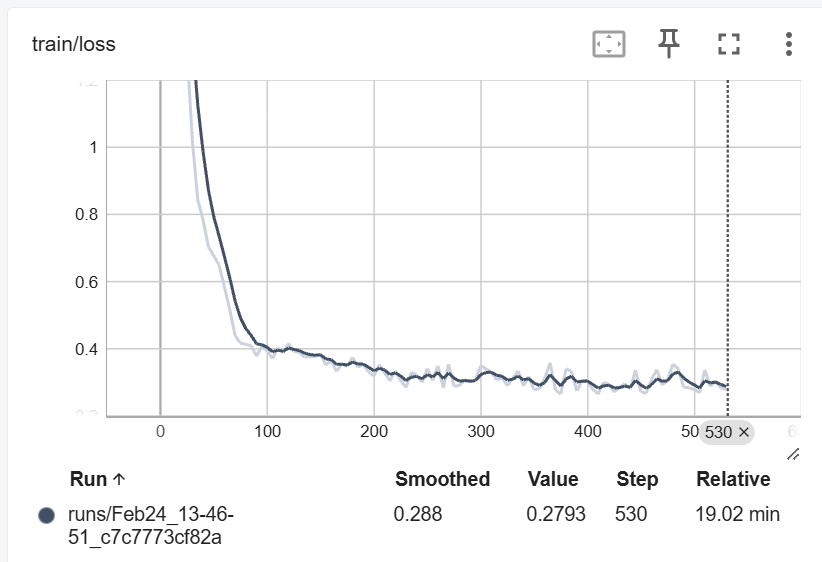

---

## Learning rate adjustments
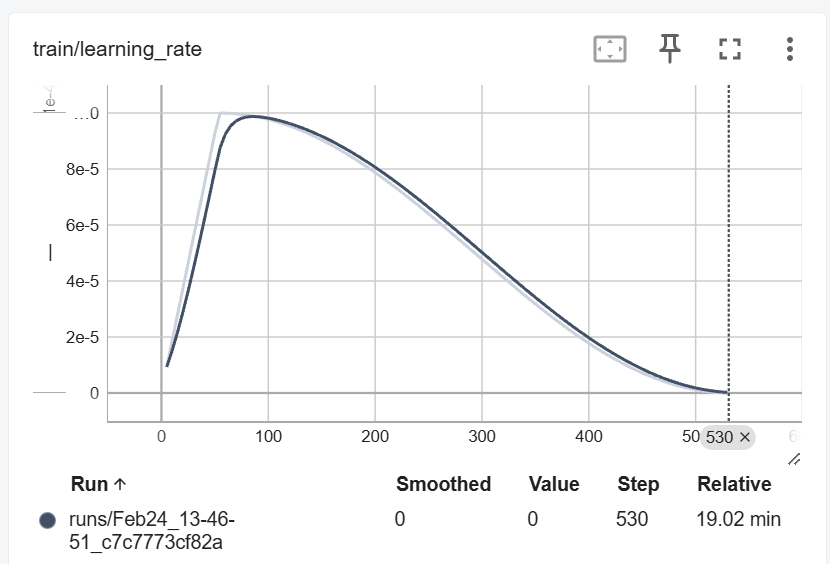

# Side note om Lora adapters
Jeg beholder Lora adapters som en PEFT model, frem for at merge vægtene ind i base modellen. På den måde kan man tillæge samme base model flere enskaber, ved at skifte lora adapteren ud med en anden, uden at skulle loade en ny model.

> **Understanding LoRA and Adapters:  "Plug-in" Fine-tuning**
> LoRA (Low-Rank Adaptation) is a parameter-efficient fine-tuning technique.  The core idea is to avoid modifying the massive weights of the pre-trained base model directly. Instead, LoRA introduces a small number of new, trainable parameters, called "adapters."

> These adapters are like "plug-ins" or "add-ons" to the original model. During fine-tuning:

> The original weights of the base model remain frozen (unchanged). They are not updated by backpropagation.
Only the weights of the LoRA adapters are trained. These are much smaller than the original model weights, making training efficient.
During inference (and evaluation), the LoRA adapter is applied to the base model on-the-fly. When you perform a forward pass through the model, the calculations are modified to incorporate the contributions from the LoRA adapters.  Think of it as the model dynamically adjusting its behavior based on the learned adapter during each forward pass.

> While the default approach is to keep adapters separate and apply them dynamically, PEFT does provide a way to merge the LoRA adapters into the base model weights. This is done using the `model.merge_and_unload()` method in PEFT.

# Test
Vi loader peft modellen og giver en et værktøj at kalde.

In [2]:
!pip install -q -U bitsandbytes
!pip install -q -U peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.0 MB/s eta 0:00:00


In [1]:
import json
import re
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

def extract_tool_call(generated_text):
    # Extract the content between <tool_call> tags
    pattern = r"(?<=<tool_call>).*?(?=</tool_call>)"
    match = re.findall(pattern, generated_text, re.DOTALL | re.MULTILINE)

    if not match:
        return None

    # Get the content inside tool_call tags
    tool_call_content = match[2]

    try:
        # Replace single quotes with double quotes for JSON compatibility
        tool_call_json = tool_call_content.replace("'", '"')

        # Parse the JSON
        tool_data = json.loads(tool_call_json)
        return tool_data

    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return None


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True)

username = "publicfax"
output_dir = "gemma-2-2B-it-thinking-function_calling-V0"
peft_model_id = f"{username}/{output_dir}"


config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(peft_model_id)
model.resize_token_embeddings(len(tokenizer))
model = PeftModel.from_pretrained(model, peft_model_id)
model.to(torch.bfloat16)
model.eval()


def get_current_temperature(location: str):
    """
    A tool that gets the temperature at a given location.

    Args:
        location: A string representing a valid city (e.g., 'New York').
    """
    if (location == "Copenhagen"):
        return -7000.2
    return 20.0


tools = [get_current_temperature]

user_prompt = """
You are a function calling AI model. You are provided with function signatures within <tools></tools> XML tags.
You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug into functions.
Here are the available tools:
<tools>
[
    {
        'type': 'function',
        'function': {'name': 'get_current_temperature', 'description': 'A tool that gets the temperature at a given location',
        'parameters': {'type': 'object', 'properties': {'location': {'type': 'string', 'description': 'A string representing a valid city (e.g., 'New York')'}},
        'required': ['location']
    }
]
</tools>
Use the following pydantic model json schema for each tool call you will make: {'title': 'FunctionCall', 'type': 'object', 'properties': {'arguments': {'title': 'Arguments', 'type': 'object'}, 'name': {'title': 'Name', 'type': 'string'}}, 'required': ['arguments', 'name']}
For each function call return a json object with function name and arguments within <tool_call></tool_call> XML tags as follows:
<tool_call>
{tool_call}
</tool_call>
Also, before making a call to a function take the time to plan the function to take. Make that thinking process between <think>{your thoughts}</think>

Hi, I need to know what the weather is like in Copenhagen. Can you help me with that?
"""

chat = [
    {"role": "user", "content": user_prompt}
]

tool_prompt = tokenizer.apply_chat_template(
    chat,
    tools=tools,
    add_generation_prompt=True,
    return_tensors="pt"
)
tool_prompt = tool_prompt.to(model.device)
out = model.generate(tool_prompt, max_new_tokens=300)
generated_text = tokenizer.decode(out[0])
print("************ Start 1 prompt ************")
print(generated_text)
print("************ End 1 prompt ************")
tool = extract_tool_call(generated_text)

result = None

if tool:

    try:
        # Map model tool call name to the corresponding function
        if tool["name"] == "get_current_temperature":
            location = tool["arguments"].get("location", "")
            # Call the weather tool function with the provided location
            result = get_current_temperature(location)
            print("************ Tool call ************")
            print("Tool call result: ", result)
            print("************ End Tool call ************")
        else:
            print("No mapping for tool:", tool["name"])
    except Exception as e:
        print("Failed to parse tool call:", e)
else:
    print("No tool call found in model output.")

chat.append({"role": "tool", "content": f"{result}"})
user_prompt = tokenizer.apply_chat_template(
    chat,
    add_generation_prompt=True,
    return_tensors="pt"
)
user_prompt = user_prompt.to(model.device)
outputs = model.generate(user_prompt, max_new_tokens=300)

print("************ Start 2 prompt ************")
print(final_output := tokenizer.decode(outputs[0]))
print("************ End 2 prompt ************")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:543: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


************ Start 1 prompt ************
<bos><start_of_turn>user
You are a function calling AI model. You are provided with function signatures within <tools></tools> XML tags.
You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug into functions.
Here are the available tools:
<tools> 
[
    {
        'type': 'function', 
        'function': {'name': 'get_current_temperature', 'description': 'A tool that gets the temperature at a given location', 
        'parameters': {'type': 'object', 'properties': {'location': {'type': 'string', 'description': 'A string representing a valid city (e.g., 'New York')'}}, 
        'required': ['location']
    }
] 
</tools>
Use the following pydantic model json schema for each tool call you will make: {'title': 'FunctionCall', 'type': 'object', 'properties': {'arguments': {'title': 'Arguments', 'type': 'object'}, 'name': {'title': 'Name', 'type': 'string'}}, 'required': ['arguments', 'name']}


Gemma2 modellen kan nu kalde tools og bruge light udgaven af thinking steps.


```
<start_of_turn>model
<think>
  Okay, so the user is asking about the weather in Copenhagen. I need to figure out how to respond.
  Looking at the available tools, there's a function called get_current_temperature that can provide the
  current temperature at a specific location. The user provided the city, so I can use that as the location parameter.
  I should call this function to get the information the user is looking for.
</think>
<tool_call>
  {'name': 'get_current_temperature', 'arguments': {'location': 'Copenhagen'}}
</tool_call>
<end_of_turn>

```

